<a href="https://colab.research.google.com/github/NegarMov/MRI-Hippocampus-Segmentation/blob/main/MRI_Hippocampus_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required packages

In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4aca3cf2d5a184f717f013c286ca0623433020a00c684b2720cb77bcab0edeef
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=72024e94246f916ae4f85daee6282228cfc075720858bb941767a45f9b57a3a1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
import kagglehub
import shutil
import os
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim.lr_scheduler as lr_scheduler

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torchvision import transforms

# Define constants

In [3]:
image_size = 256
batch_size = 32
learning_rate = 1e-3
num_epochs = 100

# Set the Random Seed

In [4]:
SEED = 0

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Download the dataset from Kaggle

In [5]:
path = kagglehub.dataset_download("sabermalek/mrihs")

shutil.copytree(path, '/content/dataset')

100%|██████████| 159M/159M [00:02<00:00, 80.5MB/s]

Extracting files...


'/content/dataset'

# Load the dataset

All the folders are renamed to ensure name consistency. This will make the future steps of loading the dataset easier.

In [6]:
def rename_folders(root_dir):
  for old_dir in os.listdir(root_dir):
    os.rename(
      os.path.join(root_dir, old_dir),
      os.path.join(root_dir, '_'.join(old_dir.split('_')[:5]))
    )

rename_folders('/content/dataset/label/100label')
rename_folders('/content/dataset/label/35label')
rename_folders('/content/dataset/original/100')
rename_folders('/content/dataset/original/35')

Only non-empty masks (masks containing at least one pixel with a value other than that of the background) are chosen.

In [7]:
def valid_mask(image_path):
    img = Image.open(image_path).convert('L')
    pixels = img.getdata()
    return np.min(pixels) != np.max(pixels)

In [8]:
def load_images_from_folder(image_dir, label_dir):
  images_path = []
  labels_path = []

  for filename in os.listdir(label_dir):
    left_dir = os.path.join(label_dir, filename, filename + '_L')
    right_dir = os.path.join(label_dir, filename, filename + '_R')
    img_dir = os.path.join(image_dir, filename)

    # check if all the needed directories exist, if not, skip the file
    if not (os.path.isdir(left_dir) and os.path.isdir(right_dir) and os.path.isdir(img_dir)):
      print(f'skipped {filename}...')
      continue

    # rename image files to ensure consistent file names
    for label in os.listdir(left_dir):
      os.rename(os.path.join(left_dir, label), os.path.join(left_dir, label.split('_')[-1]))
    for label in os.listdir(right_dir):
      os.rename(os.path.join(right_dir, label), os.path.join(right_dir, label.split('_')[-1]))
    for img in os.listdir(img_dir):
      os.rename(os.path.join(img_dir, img), os.path.join(img_dir, img.split('_')[-1]))

    for id in os.listdir(left_dir):
      left_label = os.path.join(left_dir, id)
      right_label = os.path.join(right_dir, id)
      img = os.path.join(img_dir, id)

      if valid_mask(left_label) or valid_mask(right_label):
        images_path.append(img)
        labels_path.append((left_label, right_label))

  return images_path, labels_path

In [9]:
train_images, train_labels = load_images_from_folder('/content/dataset/original/100', '/content/dataset/label/100label')
test_images, test_labels = load_images_from_folder('/content/dataset/original/35', '/content/dataset/label/35label')

len(train_images), len(test_images)

skipped ADNI_013_S_0325_85153...


(2969, 1055)

In [10]:
class MRI_Dataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    image = Image.open(img_path).convert('RGB')

    label_path = self.labels[idx]
    mask1 = cv2.imread(label_path[0], cv2.IMREAD_GRAYSCALE)
    mask2 = cv2.imread(label_path[1], cv2.IMREAD_GRAYSCALE)
    label = cv2.bitwise_or(mask1, mask2)

    return {
      "images": image,
      "labels": Image.fromarray(label)
    }

The wrapper dataset handles the application of different transformation functions to the training, validation, and test sets.

In [11]:
class WrapperDataset:
  def __init__(self, dataset, dataset_type):
    self.dataset = dataset

    self.label_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
    ])

    self.base_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.aug_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.dataset_type = dataset_type

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    images = self.dataset[index]["images"]
    labels = self.dataset[index]["labels"]

    # apply data augmentation
    if self.dataset_type == 'train' and random.random() < 0.5:
      images = images.transpose(Image.FLIP_LEFT_RIGHT)
      labels = labels.transpose(Image.FLIP_LEFT_RIGHT)

    return {
      "images": self.aug_transform(images) if self.dataset_type == 'train' else self.base_transform(images),
      "labels": self.label_transform(labels)
    }

In [12]:
train_val_dataset = MRI_Dataset(train_images, train_labels)

train_idx, val_idx = train_test_split(
  np.arange(len(train_val_dataset)),
  test_size=0.2,
  random_state=SEED,
  shuffle=True
)

train_dataset = WrapperDataset(Subset(train_val_dataset, train_idx), 'train')
val_dataset = WrapperDataset(Subset(train_val_dataset, val_idx), 'val')
test_dataset = WrapperDataset(MRI_Dataset(test_images, test_labels), 'test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset), len(test_dataset)

(2375, 594, 1055)

# Set up the model

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.unet = smp.Unet(
            encoder_name="efficientnet-b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
        )

    def forward(self, img):
        out = self.unet(img)

        return out

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [16]:
def initiate_model():
  model = UNet()
  model.to(device)

  criterion = (DiceLoss(mode="binary"), nn.BCEWithLogitsLoss())

  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
  )

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode='min',
      threshold=5*1e-3,
      patience=2,
      factor=0.5,
  )

  return model, criterion, optimizer, scheduler

# Train the model

In [17]:
def dice_score(preds, targets, eps=1e-8):
    preds = (preds.sigmoid() > 0.5).float()

    intersection = (preds * targets).sum()

    return (2. * intersection + eps) / (preds.sum() + targets.sum() + eps)

In [22]:
model, criterion, optimizer, scheduler = initiate_model()

train_loss, train_dice = [], []
val_loss, val_dice = [], []

for e in tqdm(range(num_epochs)):

  if scheduler.get_last_lr()[-1] < learning_rate * (0.5 ** 4):
        break

  # training
  model.train()

  avg_loss, avg_dice, total_samples = 0, 0, 0
  for train_data in train_loader:

    img_train = train_data["images"].to(device)
    label_train = train_data["labels"].to(device)

    optimizer.zero_grad()

    label_pred = model(img_train)

    loss = criterion[0](label_pred, label_train) + criterion[1](label_pred, label_train)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    avg_loss += loss.item()
    avg_dice += dice_score(label_pred, label_train).item()
    total_samples += len(img_train)

  train_loss.append(avg_loss / len(train_loader))
  train_dice.append(avg_dice / len(train_loader))

  # evaluation
  model.eval()
  with torch.no_grad():
    avg_loss, avg_dice, total_samples = 0, 0, 0
    for val_data in val_loader:

      img_val = val_data["images"].to(device)
      label_val = val_data["labels"].to(device)

      label_pred = model(img_val)

      loss = criterion[0](label_pred, label_val) + criterion[1](label_pred, label_val)

      avg_loss += loss.item()
      avg_dice += dice_score(label_pred, label_val).item()
      total_samples += len(img_val)

    val_loss.append(avg_loss / len(val_loader))
    val_dice.append(avg_dice / len(val_loader))

  print(f"\nLR: {scheduler.get_last_lr()}")
  print(f"Train Loss: {train_loss[-1]} - Validation Loss: {val_loss[-1]}")
  print(f"Train Dice Score: {train_dice[-1]} - Validation Dice Score: {val_dice[-1]}")

  scheduler.step(val_loss[-1])

  1%|          | 1/100 [00:54<1:29:57, 54.52s/it]


LR: [0.001]
Train Loss: 1.009339582125346 - Validation Loss: 0.5362843996600101
Train Dice Score: 0.4294782540325765 - Validation Dice Score: 0.7150533889469347


  2%|▏         | 2/100 [01:52<1:32:47, 56.81s/it]


LR: [0.001]
Train Loss: 0.26874979158242546 - Validation Loss: 0.354512914230949
Train Dice Score: 0.8047608232498169 - Validation Dice Score: 0.6866973920872337


  3%|▎         | 3/100 [02:47<1:29:54, 55.62s/it]


LR: [0.001]
Train Loss: 0.17442388733228048 - Validation Loss: 0.21822791664223923
Train Dice Score: 0.8444855713844299 - Validation Dice Score: 0.8055013292714169


  4%|▍         | 4/100 [03:41<1:28:11, 55.12s/it]


LR: [0.001]
Train Loss: 0.15325095335642497 - Validation Loss: 0.18641899918255053
Train Dice Score: 0.8602497951189677 - Validation Dice Score: 0.8427846118023521


  5%|▌         | 5/100 [04:35<1:26:52, 54.87s/it]


LR: [0.001]
Train Loss: 0.14800248364607493 - Validation Loss: 0.1560832740444886
Train Dice Score: 0.8637004288037619 - Validation Dice Score: 0.8575494508994254


  6%|▌         | 6/100 [05:31<1:26:05, 54.95s/it]


LR: [0.001]
Train Loss: 0.13681508342425028 - Validation Loss: 0.14514033731661344
Train Dice Score: 0.8736920420328776 - Validation Dice Score: 0.8658579211486014


  7%|▋         | 7/100 [06:25<1:24:56, 54.80s/it]


LR: [0.001]
Train Loss: 0.13326440383990606 - Validation Loss: 0.14245489945537165
Train Dice Score: 0.8764352440834046 - Validation Dice Score: 0.8673623172860396


  8%|▊         | 8/100 [07:20<1:24:03, 54.82s/it]


LR: [0.001]
Train Loss: 0.1307209367553393 - Validation Loss: 0.13861826650406184
Train Dice Score: 0.8785800782839457 - Validation Dice Score: 0.8706496263805189


  9%|▉         | 9/100 [08:15<1:23:03, 54.77s/it]


LR: [0.001]
Train Loss: 0.12637862751881282 - Validation Loss: 0.1392962948272103
Train Dice Score: 0.8825297896067301 - Validation Dice Score: 0.8699592038204795


 10%|█         | 10/100 [09:10<1:22:19, 54.88s/it]


LR: [0.001]
Train Loss: 0.12313824981451034 - Validation Loss: 0.1333736549866827
Train Dice Score: 0.8854015374183655 - Validation Dice Score: 0.8753641624199716


 11%|█         | 11/100 [10:04<1:21:12, 54.75s/it]


LR: [0.001]
Train Loss: 0.12154170721769333 - Validation Loss: 0.13235015029969968
Train Dice Score: 0.8868169140815735 - Validation Dice Score: 0.8766560178054007


 12%|█▏        | 12/100 [10:58<1:20:04, 54.60s/it]


LR: [0.001]
Train Loss: 0.11817374954620997 - Validation Loss: 0.1298109767468352
Train Dice Score: 0.889992531935374 - Validation Dice Score: 0.8787304476687783


 13%|█▎        | 13/100 [11:53<1:19:02, 54.51s/it]


LR: [0.001]
Train Loss: 0.1176413278778394 - Validation Loss: 0.1301356608930387
Train Dice Score: 0.8905256215731303 - Validation Dice Score: 0.8783395008036965


 14%|█▍        | 14/100 [12:47<1:18:13, 54.57s/it]


LR: [0.001]
Train Loss: 0.11359760820865632 - Validation Loss: 0.1272380602987189
Train Dice Score: 0.8942235406239828 - Validation Dice Score: 0.8808616399765015


 15%|█▌        | 15/100 [13:43<1:17:34, 54.76s/it]


LR: [0.001]
Train Loss: 0.11170947929223378 - Validation Loss: 0.12678682804107666
Train Dice Score: 0.8958805537223816 - Validation Dice Score: 0.8811352535297996


 16%|█▌        | 16/100 [14:37<1:16:39, 54.76s/it]


LR: [0.001]
Train Loss: 0.11125704656044642 - Validation Loss: 0.1242430390496003
Train Dice Score: 0.8963486901919047 - Validation Dice Score: 0.8839164282146253


 17%|█▋        | 17/100 [15:32<1:15:37, 54.67s/it]


LR: [0.001]
Train Loss: 0.11008494466543198 - Validation Loss: 0.12962045363689723
Train Dice Score: 0.8972816125551859 - Validation Dice Score: 0.8784561063113966


 18%|█▊        | 18/100 [16:27<1:14:51, 54.77s/it]


LR: [0.001]
Train Loss: 0.10956690738598505 - Validation Loss: 0.12618353649189598
Train Dice Score: 0.8977344783147176 - Validation Dice Score: 0.881836546094794


 19%|█▉        | 19/100 [17:22<1:13:54, 54.75s/it]


LR: [0.001]
Train Loss: 0.10769242147604624 - Validation Loss: 0.1259385833614751
Train Dice Score: 0.8994908531506857 - Validation Dice Score: 0.8821044972068385


 20%|██        | 20/100 [18:16<1:12:51, 54.64s/it]


LR: [0.0005]
Train Loss: 0.10283086041609446 - Validation Loss: 0.118489754827399
Train Dice Score: 0.9041492255528768 - Validation Dice Score: 0.8891501207100717


 21%|██        | 21/100 [19:10<1:11:49, 54.55s/it]


LR: [0.0005]
Train Loss: 0.09932124892870585 - Validation Loss: 0.11818641032043256
Train Dice Score: 0.907570993900299 - Validation Dice Score: 0.8894491321162173


 22%|██▏       | 22/100 [20:05<1:10:52, 54.52s/it]


LR: [0.0005]
Train Loss: 0.09780392587184907 - Validation Loss: 0.11901487331641347
Train Dice Score: 0.908930598894755 - Validation Dice Score: 0.8887510927099931


 23%|██▎       | 23/100 [20:59<1:09:47, 54.38s/it]


LR: [0.0005]
Train Loss: 0.0960826517144839 - Validation Loss: 0.11805627181341774
Train Dice Score: 0.9108087793986003 - Validation Dice Score: 0.8895364560578999


 24%|██▍       | 24/100 [21:53<1:08:41, 54.23s/it]


LR: [0.00025]
Train Loss: 0.09269556194543839 - Validation Loss: 0.11534647878847624
Train Dice Score: 0.9140599417686462 - Validation Dice Score: 0.8919622270684493


 25%|██▌       | 25/100 [22:47<1:07:50, 54.27s/it]


LR: [0.00025]
Train Loss: 0.09182357639074326 - Validation Loss: 0.11547013607464339
Train Dice Score: 0.9148208332061768 - Validation Dice Score: 0.8921593239432887


 26%|██▌       | 26/100 [23:41<1:06:51, 54.20s/it]


LR: [0.00025]
Train Loss: 0.0904399053255717 - Validation Loss: 0.11543803152285124
Train Dice Score: 0.9161815539995829 - Validation Dice Score: 0.8920305904589201


 27%|██▋       | 27/100 [24:35<1:05:48, 54.09s/it]


LR: [0.00025]
Train Loss: 0.08965634167194367 - Validation Loss: 0.11540458272946508
Train Dice Score: 0.9169442780812581 - Validation Dice Score: 0.8918648926835311


 28%|██▊       | 28/100 [25:29<1:05:02, 54.21s/it]


LR: [0.000125]
Train Loss: 0.08763891230026881 - Validation Loss: 0.11410738606201976
Train Dice Score: 0.9189925098419189 - Validation Dice Score: 0.8932731653514662


 29%|██▉       | 29/100 [26:23<1:04:00, 54.09s/it]


LR: [0.000125]
Train Loss: 0.08698543816804886 - Validation Loss: 0.1142772608681729
Train Dice Score: 0.91978963692983 - Validation Dice Score: 0.892960858972449


 30%|███       | 30/100 [27:18<1:03:12, 54.18s/it]


LR: [0.000125]
Train Loss: 0.08720192273457845 - Validation Loss: 0.11492863179821718
Train Dice Score: 0.919561243057251 - Validation Dice Score: 0.8925518926821256


 31%|███       | 31/100 [28:11<1:02:13, 54.11s/it]


LR: [0.000125]
Train Loss: 0.08638677249352138 - Validation Loss: 0.11411620009886592
Train Dice Score: 0.9202988203366598 - Validation Dice Score: 0.8931451690824408


 32%|███▏      | 32/100 [29:06<1:01:32, 54.30s/it]


LR: [6.25e-05]
Train Loss: 0.08529180496931076 - Validation Loss: 0.11417664509070546
Train Dice Score: 0.9215279785792033 - Validation Dice Score: 0.8931153667600531


 33%|███▎      | 33/100 [30:00<1:00:32, 54.22s/it]


LR: [6.25e-05]
Train Loss: 0.08479740848143895 - Validation Loss: 0.113961072344529
Train Dice Score: 0.922011247475942 - Validation Dice Score: 0.8933200240135193


 34%|███▍      | 34/100 [30:54<1:00:00, 54.55s/it]


LR: [6.25e-05]
Train Loss: 0.08423017024993897 - Validation Loss: 0.11414924460022073
Train Dice Score: 0.9224029485384623 - Validation Dice Score: 0.8932505908765291


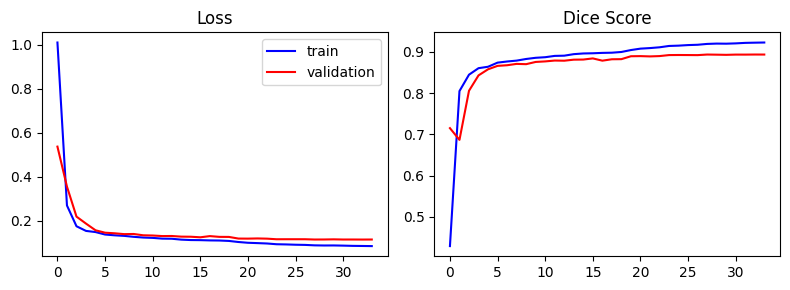

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].set_title("Loss")
axes[0].plot(train_loss, c='b', label='train')
axes[0].plot(val_loss, c='r', label='validation')
axes[0].legend()

axes[1].set_title("Dice Score")
axes[1].plot(train_dice, c='b', label='train')
axes[1].plot(val_dice, c='r', label='validation')

plt.tight_layout()
plt.show()

# Inference

In [24]:
def show_image_set(img_id):
  test_img = Image.open(test_images[img_id]).convert('L')

  test_l = transforms.ToPILImage()(test_dataset[img_id]["labels"]).resize(test_img.size)

  pred = model(test_dataset[img_id]["images"].unsqueeze(0).to(device)).sigmoid()
  test_pred = transforms.ToPILImage()(pred[0]).resize(test_img.size)

  fig, axes = plt.subplots(1, 3, figsize=(6, 2.5))

  axes[0].imshow(test_img, cmap='gray')
  axes[0].set_title("MRI Image")
  axes[0].axis('off')

  axes[1].imshow(test_l, cmap='gray')
  axes[1].set_title("Original Mask")
  axes[1].axis('off')

  axes[2].imshow(test_pred, cmap='gray')
  axes[2].set_title("Predicted Mask")
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

Show the result for 5 random samples of the test set.

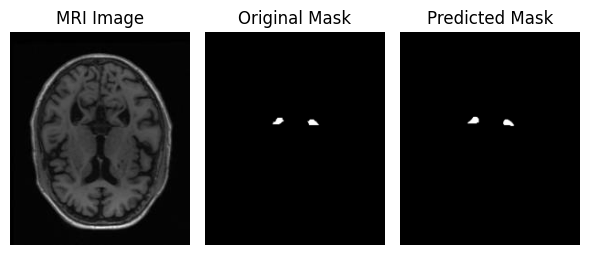

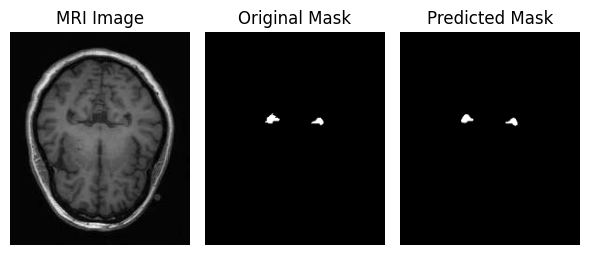

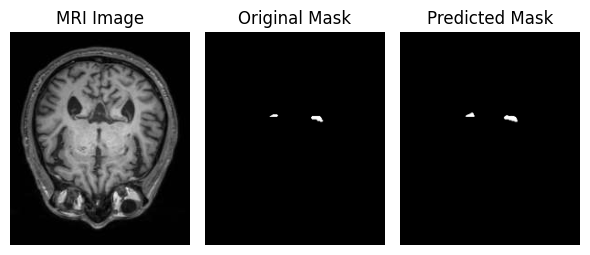

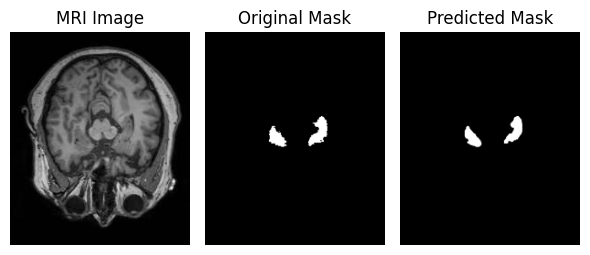

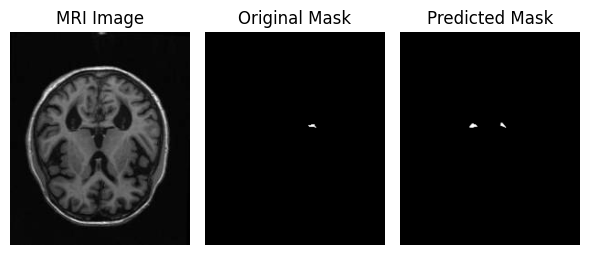

In [27]:
for i in random.sample(range(len(test_dataset)), 5):
  show_image_set(i)

In [45]:
model.eval()
with torch.no_grad():
  avg_dice = 0
  for test_data in test_loader:

    img_test = test_data["images"].to(device)
    label_test = test_data["labels"].to(device)

    label_pred = model(img_test)
    avg_dice += dice_score(label_pred, label_test).item()

print(f"Test Dice Score: {avg_dice / len(test_loader)}")

Test Dice Score: 0.8280294709133379
